In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-11-23_16-35_20200101_20200831.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.0022766078542970974

In [5]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [6]:
#df = df.loc['20190101':'20190701']

In [7]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [8]:
allocs

NQ       0.25
ES       0.25
YM       0.25
GC       0.25
total    1.00
dtype: float64

In [9]:
df.groupby('contract').realizedPNL.sum()

contract
ES     2179.70
GC     8795.88
NQ    12051.60
YM    19104.20
Name: realizedPNL, dtype: float64

In [10]:
df.realizedPNL.sum()

42131.380000000005

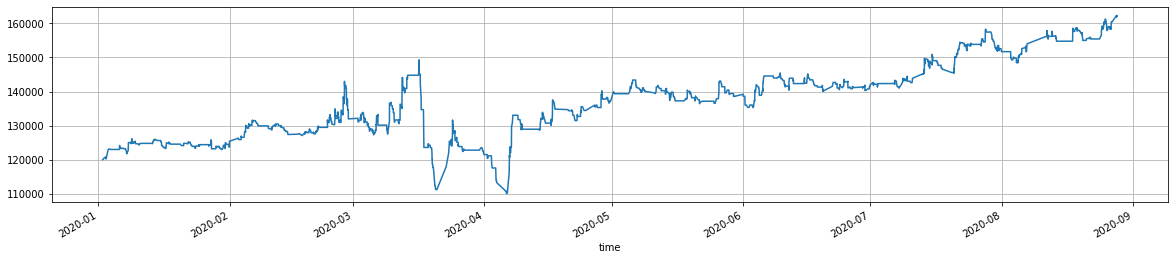

In [11]:
df.cash.plot(figsize=(20,4), grid=True);

In [12]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [13]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES    219
 GC    386
 NQ    904
 YM    248
 Name: action, dtype: int64,
 1757)

In [14]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.273256
 GC    2.244186
 NQ    5.255814
 YM    1.441860
 Name: action, dtype: float64,
 10.215116279069768)

In [15]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES     459.90
GC     934.12
NQ    1898.40
YM     520.80
Name: commission, dtype: float64

In [16]:
df.commission.sum()

3813.2200000000003

In [17]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
NQ,0.42,26.66,704.18,-469.14,1.50,23.65,452.0
GC,0.38,45.57,1043.67,-575.09,1.81,40.04,193.0
YM,0.48,154.07,1198.97,-825.53,1.45,146.23,124.0
ES,0.37,20.00,1860.49,-1046.95,1.78,28.80,109.0
total,0.42,47.99,981.06,-615.90,1.59,54.82,878.0


In [18]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,-0.080139,0.193628,0.496206,0.733746
GC,-0.080139,1.000000,-0.138765,-0.121557,0.264126
NQ,0.193628,-0.138765,1.000000,0.139996,0.556076
YM,0.496206,-0.121557,0.139996,1.000000,0.672655
total,0.733746,0.264126,0.556076,0.672655,1.000000


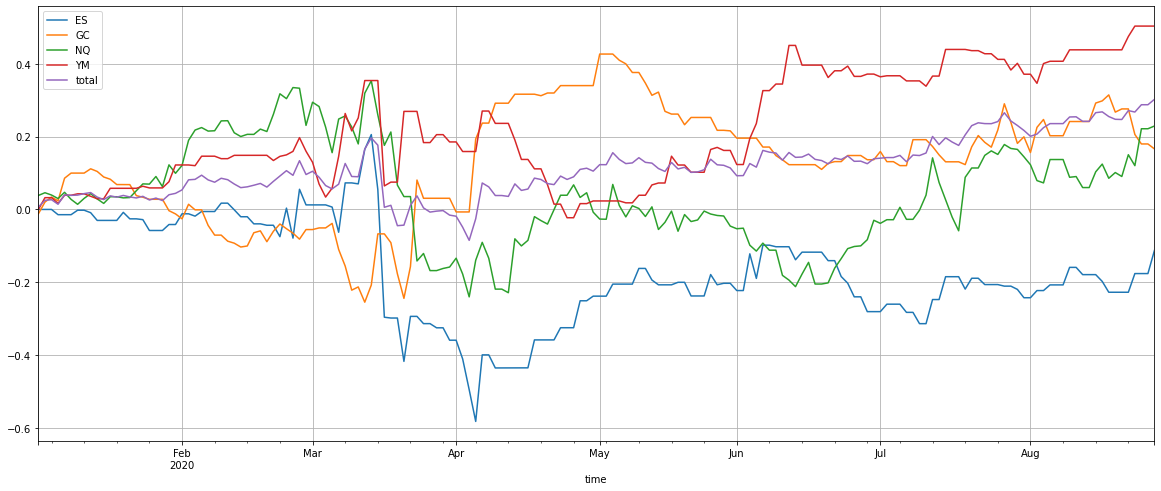

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

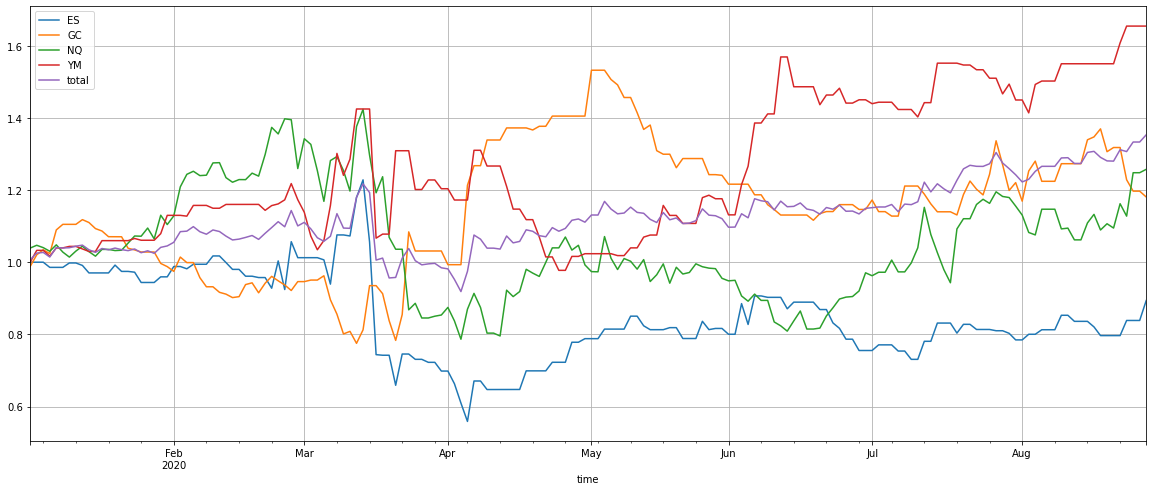

In [21]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,-0.151931,0.275707,0.398744,1.090893,0.557264
Cumulative returns,-0.106383,0.180808,0.257396,0.654395,0.352991
Annual volatility,0.724678,0.634095,0.715569,0.621362,0.375011
Sharpe ratio,0.146893,0.677448,0.822515,1.501533,1.371680
Calmar ratio,-0.278719,0.899067,0.890840,3.475449,2.273188
Stability,0.195709,0.308368,0.033297,0.616610,0.682258
Max drawdown,-0.545107,-0.306659,-0.447604,-0.313885,-0.245146
Omega ratio,1.039267,1.176824,1.162272,1.496136,1.317934
Sortino ratio,0.210302,1.397348,1.264106,2.400361,2.041438
Skew,-0.673138,3.041333,0.323799,-0.060050,-0.896642


In [23]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2020-01-31,-4.06,-1.22,10.44,12.99,4.51
2020-02-29,5.54,-4.21,14.05,3.84,5.31
2020-03-31,-31.03,8.97,-32.22,2.59,-10.55
2020-04-30,12.86,36.26,16.26,-14.96,12.84
2020-05-31,3.59,-11.68,-3.75,14.88,0.88
2020-06-30,-7.49,-7.62,1.60,23.32,2.55
2020-07-31,3.89,6.49,19.05,-0.04,8.09
2020-08-31,13.88,-3.26,8.82,14.13,8.91


In [24]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES      -11.0
GC       18.0
NQ       26.0
YM       65.0
total    35.0
dtype: float64

In [25]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2020-03-22 23:03:00,YM,BUY,18125.00,6430.80
2020-03-12 14:30:00,ES,BUY,2558.50,6333.30
2020-04-07 08:54:00,ES,SELL,2686.25,5520.80
2020-03-09 14:49:00,ES,BUY,2743.75,5320.80
2020-03-16 14:00:30,GC,BUY,1454.10,4525.16
...,...,...,...,...
2020-03-20 07:41:30,ES,BUY,2423.50,-3366.70
2020-03-16 14:55:00,ES,BUY,2449.75,-4204.20
2020-03-17 16:09:30,ES,BUY,2454.50,-4241.70


In [26]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2020-04-07,0.200553,0.044677,0.050387,0.117553,0.103293
2020-03-12,0.099303,-0.040989,0.149440,0.108053,0.078952
2020-04-06,-0.083473,0.221677,0.105800,0.000000,0.061001
2020-03-09,0.145137,-0.044495,0.008527,0.124860,0.058507
2020-03-23,0.131527,0.091344,0.000000,0.000000,0.055718
...,...,...,...,...,...
2020-03-10,0.000000,-0.063989,-0.029893,-0.046640,-0.035131
2020-04-03,-0.080973,0.000000,-0.060780,0.000000,-0.035438
2020-02-28,-0.041950,0.026688,-0.097033,-0.036700,-0.037249
